In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
import math

%matplotlib inline

In [2]:
def display_image_set(images, filename, cols_num=6):
    imgs_num = len(images)
    width_img = int(math.ceil(float(300) / float(cols_num)))
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    height_init, width_init, channel = images[0].shape
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, channel)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)
    
    for idx, img in enumerate(images):
        row = idx // cols_num
        col = idx - row * cols_num

        img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.rcParams["figure.figsize"] = (25, 25)
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def crop_roi(image, top_left, top_right, bottom_right, bottom_left):
    roi = [np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.int32)]
    return region_of_interest(image, roi)

def crop_by_ref(img, ref_width, ref_height, ref_top_x, ref_top_y, ref_bot_x, ref_bot_y):
    width = img.shape[1]
    image_height = img.shape[0]
    middle_x = int(width / 2)
    image_offset_bottom_x = int(width * ref_bot_x / ref_width)
    image_offset_bottom_y = int(image_height * ref_bot_y / ref_height)
    image_offset_top_x = int(width * ref_top_x / ref_width)
    image_offset_top_y = int(image_height * ref_top_y / ref_height)
    top_left = [middle_x - image_offset_top_x, image_offset_top_y]
    top_right = [middle_x + image_offset_top_x, image_offset_top_y]
    bottom_right = [width - image_offset_bottom_x, image_offset_bottom_y]
    bottom_left = [image_offset_bottom_x, image_offset_bottom_y]

    return crop_roi(img, top_left, top_right, bottom_right, bottom_left)

def crop(image, bottom_offset = 0):
    ref_width = 960
    ref_height = 540
    ref_top_x = 50
    ref_top_y = 300
    ref_bottom_x = 70
    ref_bottom_y = 540 - bottom_offset

    return crop_by_ref(image, ref_width, ref_height, ref_top_x, ref_top_y, ref_bottom_x, ref_bottom_y)

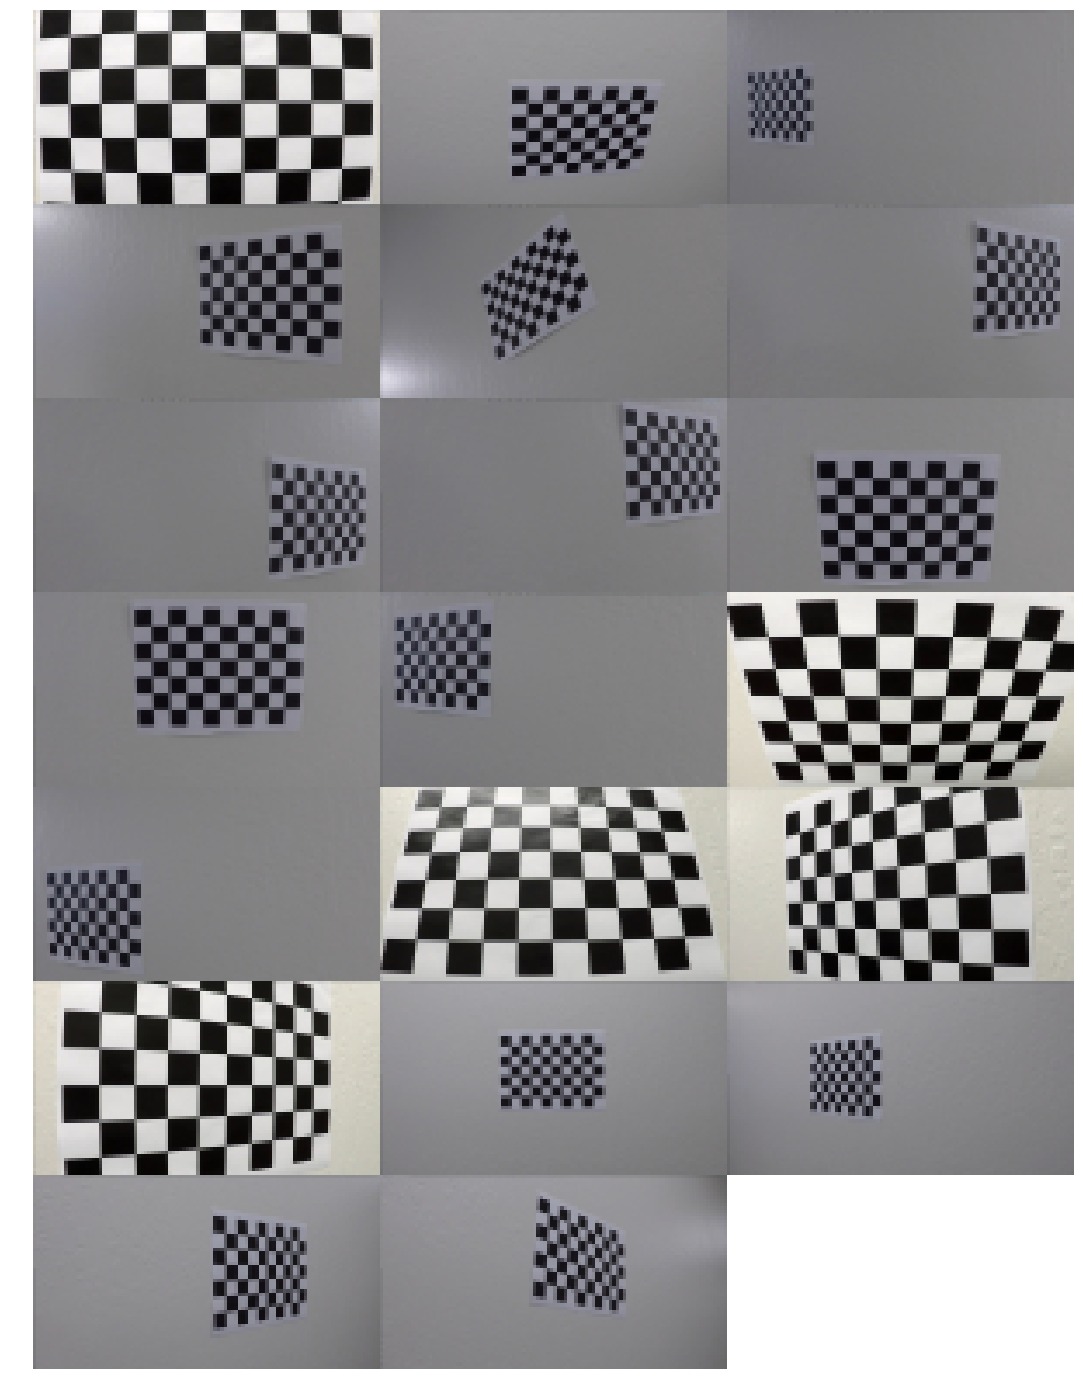

In [3]:
grids = []
files = glob.glob('./camera_cal/*.jpg')

for fname in files:
    grids.append(mpimg.imread(fname))
        
display_image_set(grids, 'calibrationGrids', cols_num=3)

Good images


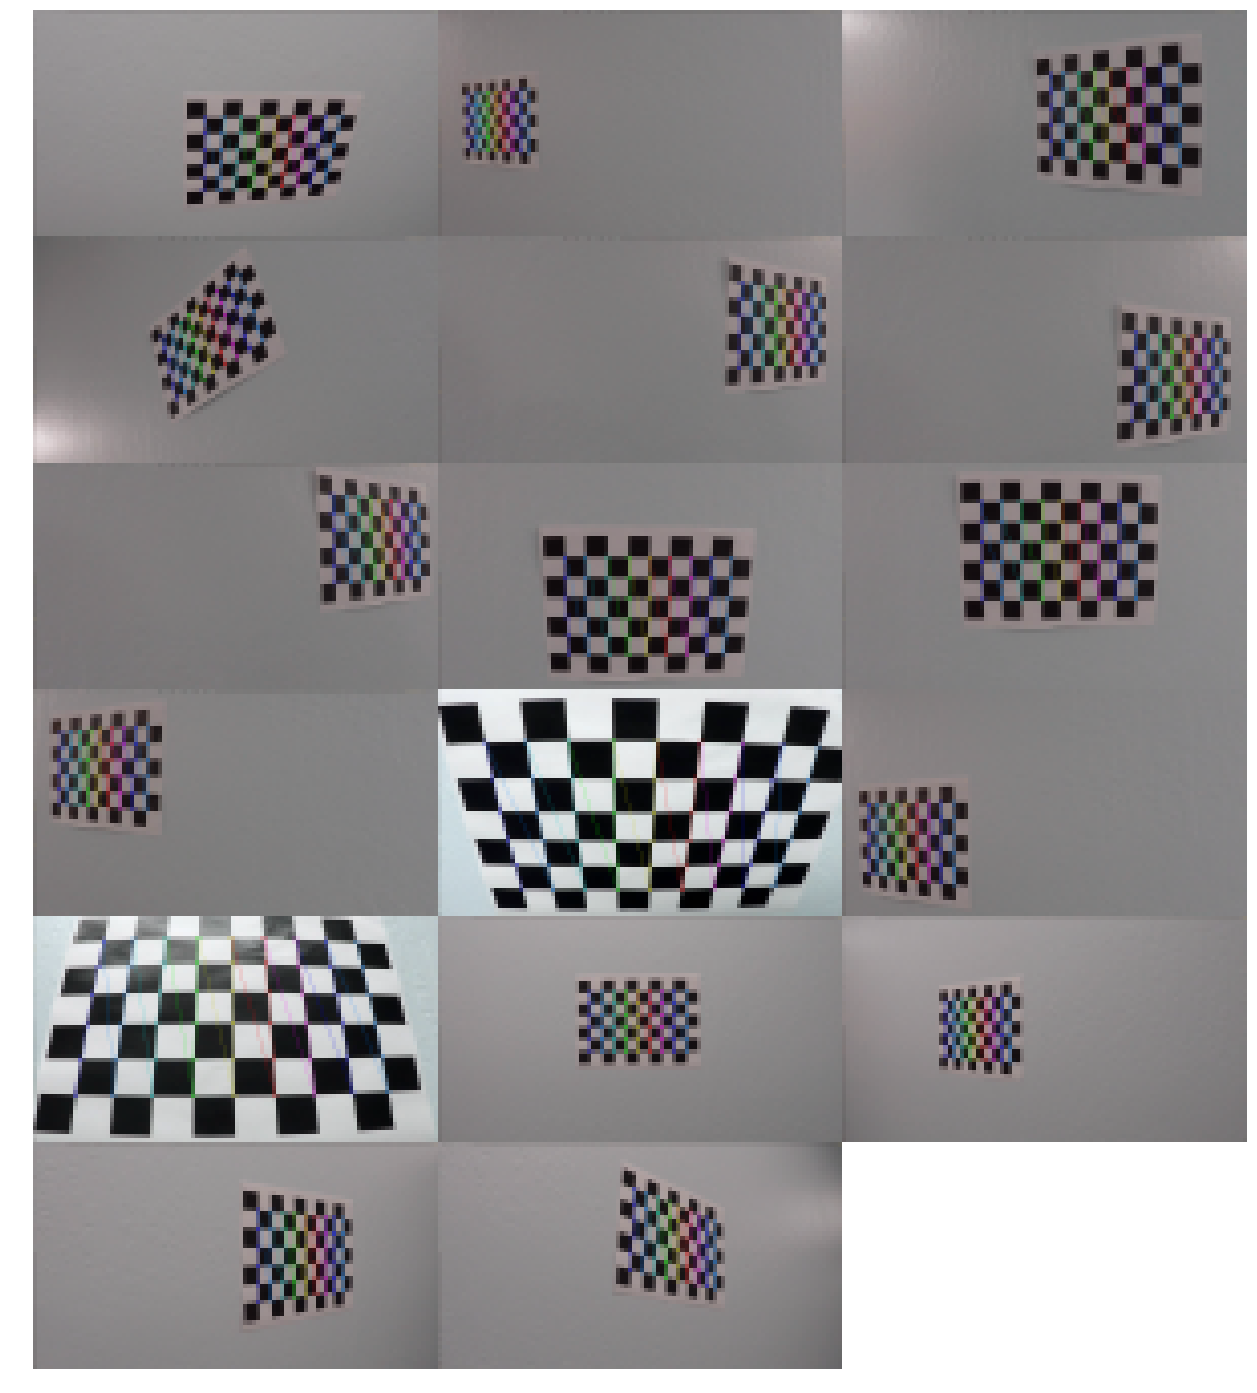


Bad images


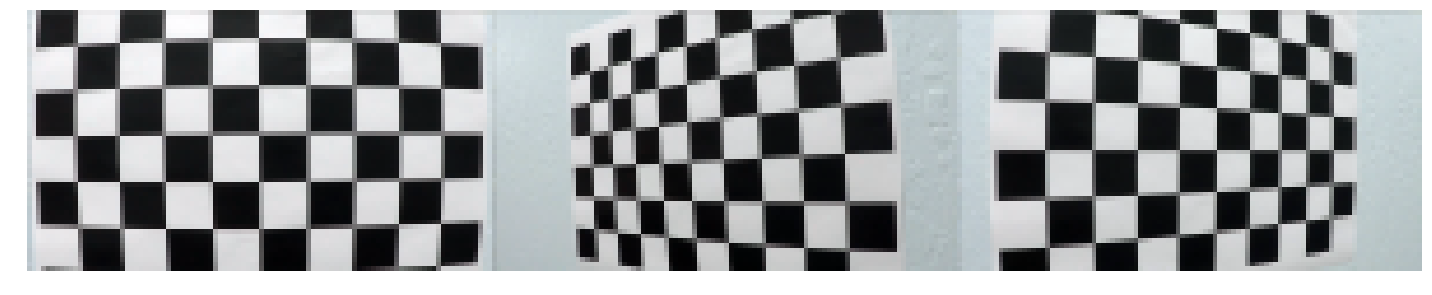

In [4]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(9,6,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)
objp = objp * 57

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
files = glob.glob('./camera_cal/*.jpg')
corner_images = []
bad_images = []

for fname in files:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (6,9), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners_refined = cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)
        img = cv2.drawChessboardCorners(img, (6,9), corners_refined, ret)
        
        objpoints.append(objp)
        imgpoints.append(corners_refined)
        corner_images.append(img)
    else:
        bad_images.append(img)

print("Good images")
display_image_set(corner_images, 'good_grids', cols_num=3)
print()
print("Bad images")
display_image_set(bad_images, 'bad_grids', cols_num=3)

grids = corner_images + bad_images

total error: 0.10820530244890393


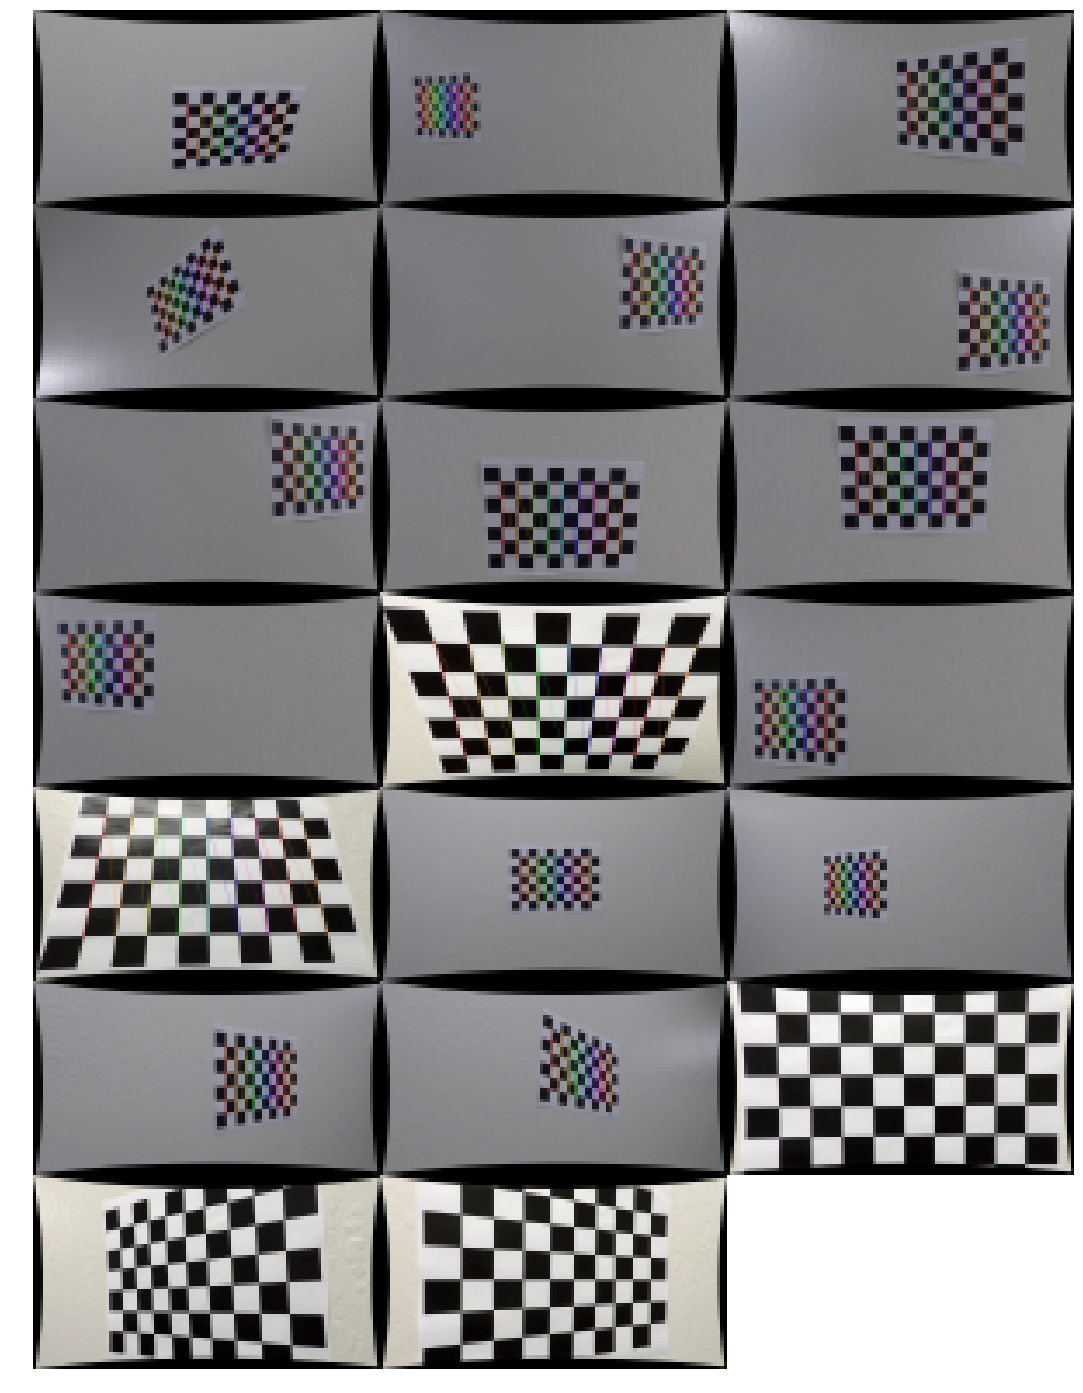

In [5]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
h, w = gray.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print("total error:", mean_error/len(objpoints))

files = glob.glob('./camera_cal/*.jpg')
grids_undist = []

for image in grids:
    grid_undist = cv2.undistort(image, mtx, dist, None, newcameramtx)
    grid_undist = cv2.cvtColor(grid_undist, cv2.COLOR_BGR2RGB)
    grids_undist.append(grid_undist)

display_image_set(grids_undist, 'undistorted_grid', cols_num=3)

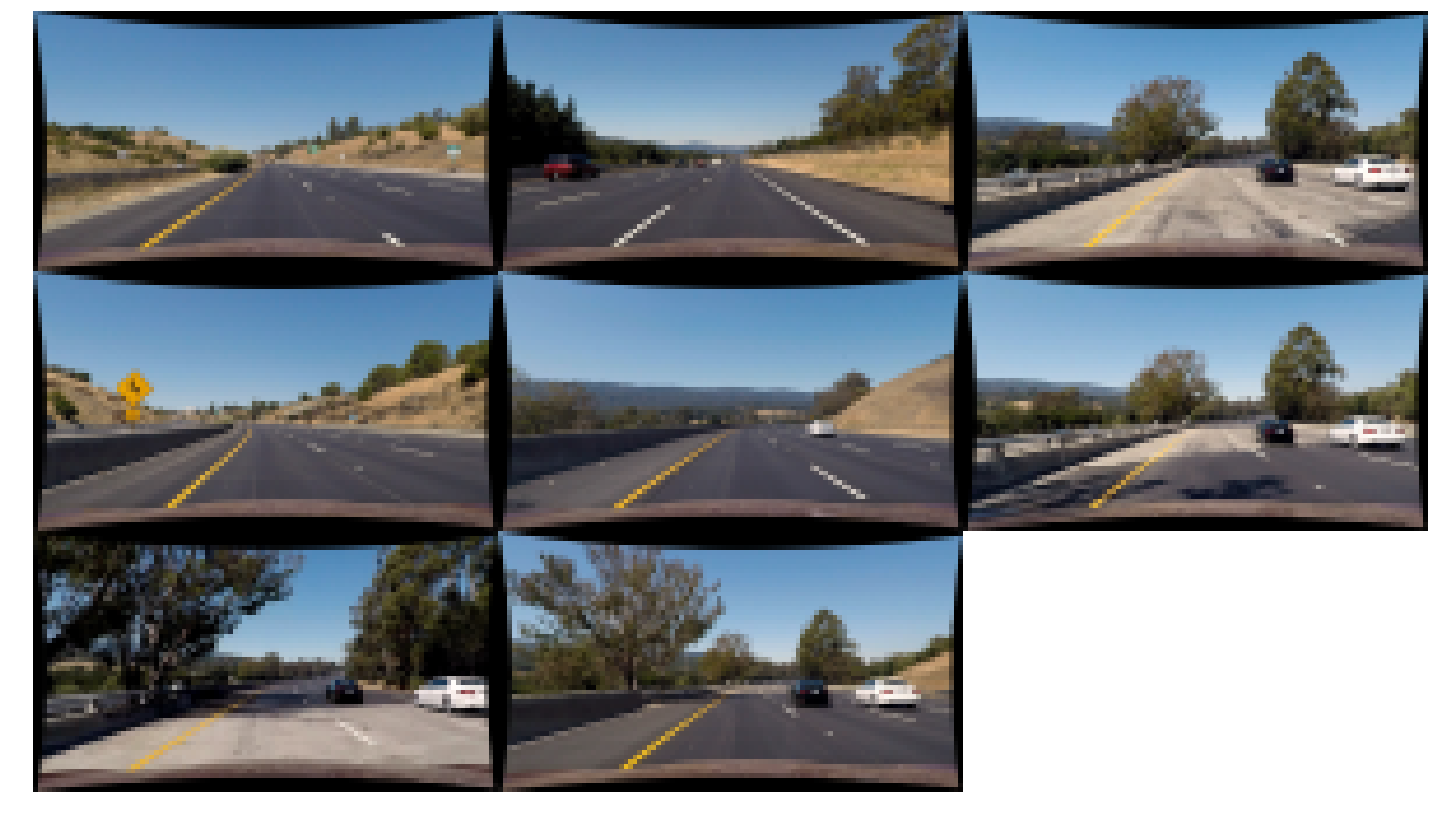

In [6]:
files = glob.glob('./test_images/*.jpg')
images_dist = []
images_undist = []

for fname in files:
    img = cv2.imread(fname)
    images_dist.append(img)
    
    img_undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    img_undist = cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB)
    images_undist.append(img_undist)

    path = './undistorted/' + os.path.basename(fname)
    cv2.imwrite(path, cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
    
display_image_set(images_undist, 'undistorted', cols_num=3)

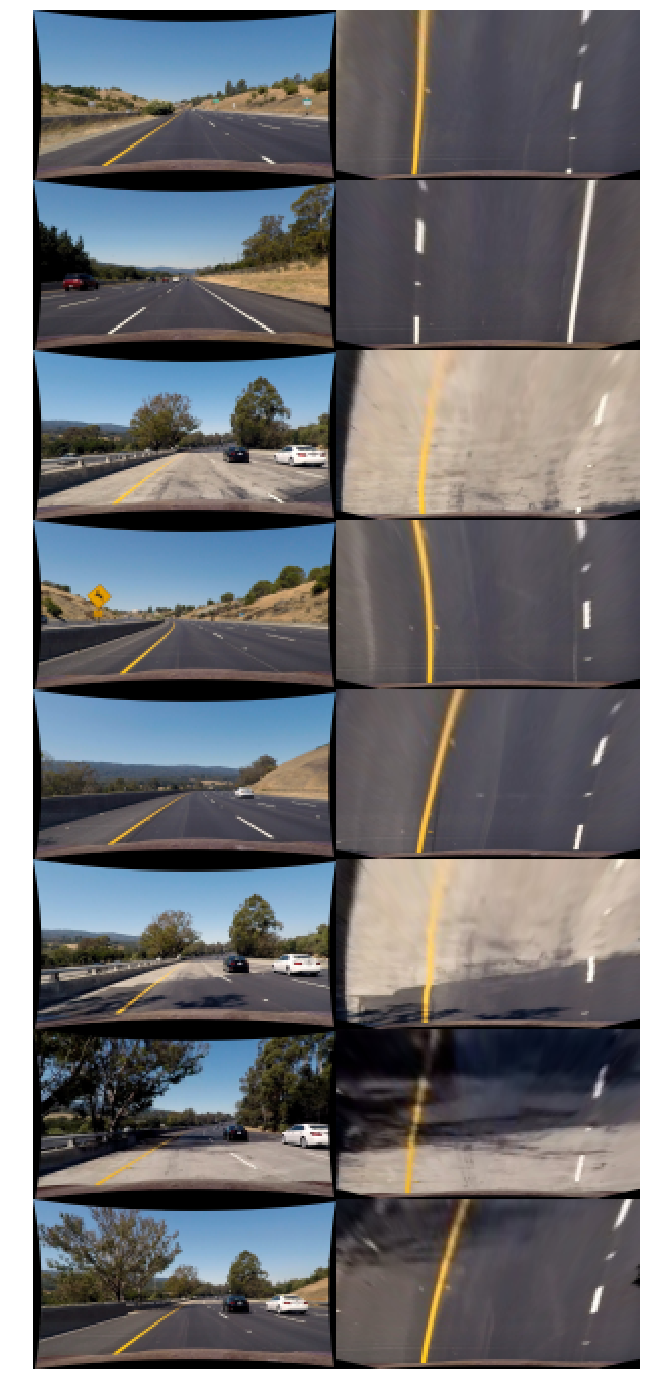

In [7]:
w,h = 1280,720
x,y = 0.5*w, 0.8*h
src = np.float32([
    [200./1280*w,720./720*h],
    [453./1280*w,547./720*h],
    [835./1280*w,547./720*h],
    [1100./1280*w,720./720*h]
])
dst = np.float32([
    [(w-x)/2.,h],
    [(w-x)/2.,0.82*h],
    [(w+x)/2.,0.82*h],
    [(w+x)/2.,h]
])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

files = glob.glob('./undistorted/*.jpg')
originals = []
unwarpeds = []

for fname in files:
    img = cv2.imread(fname)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    originals.append(rgb)
    
    image_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, dsize = image_size, flags = cv2.INTER_LINEAR)
    rgb_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
    unwarpeds.append(rgb_warped)

result = [j for i in zip(originals, unwarpeds) for j in i]

display_image_set(result, 'unwraped', cols_num=2)

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag / scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def hls_select(img, s_thresh=(0, 255), sx_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    
    l_channel = hls[:,:,1]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    return np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

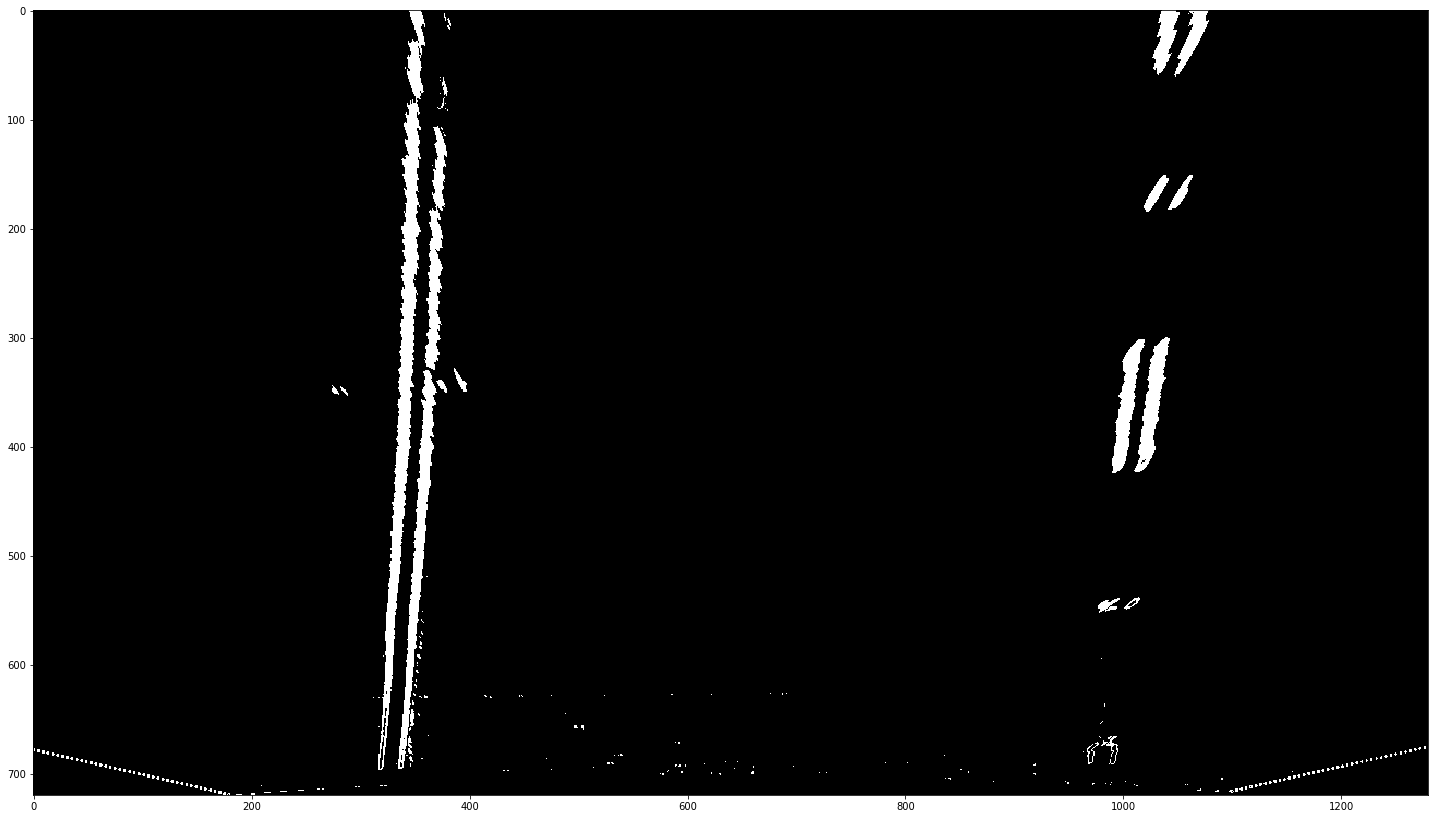

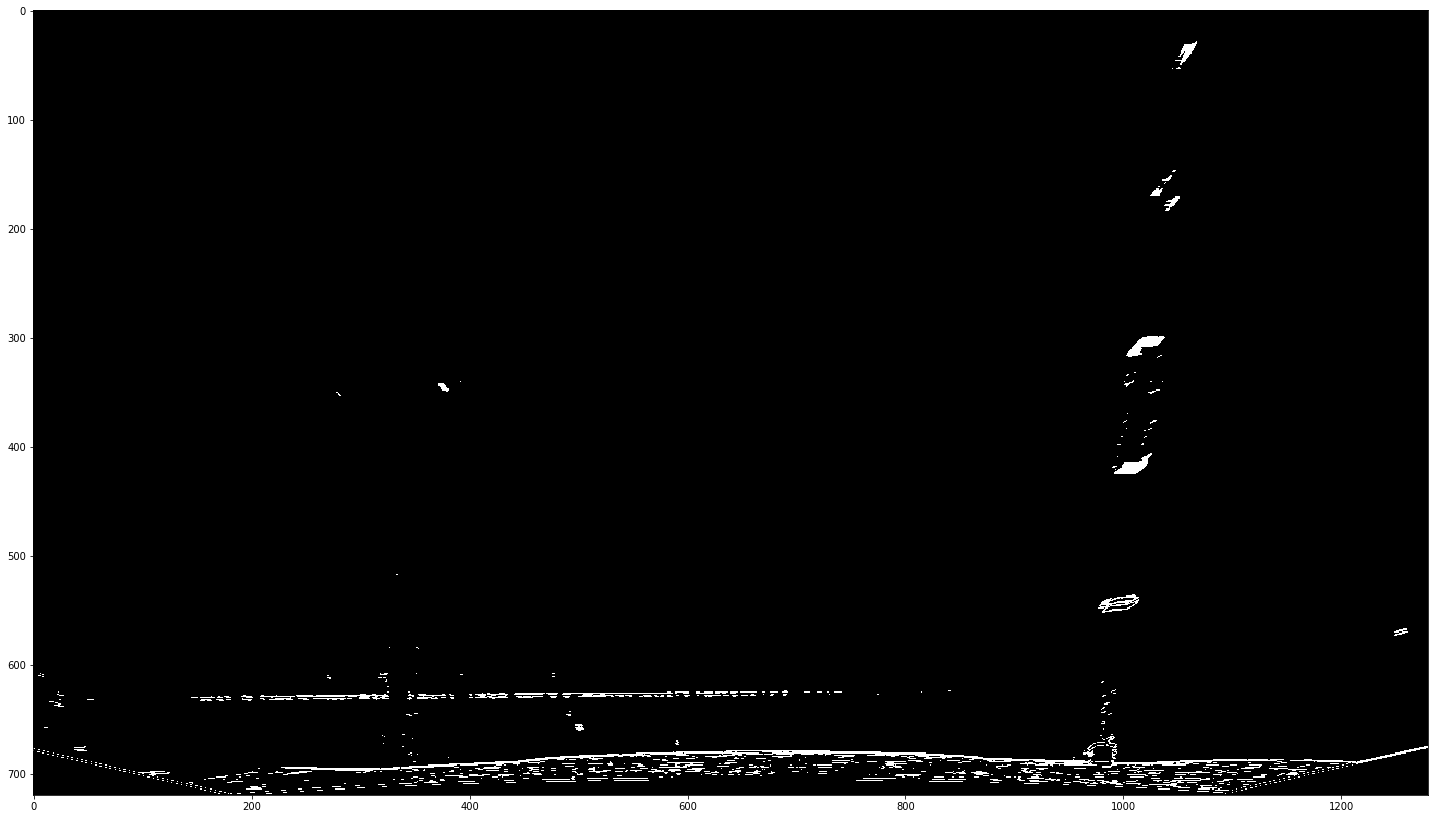

In [9]:
img = unwarpeds[0]

gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)

plt.figure(figsize=(25,25))
plt.imshow(gradx, cmap='gray')

plt.figure(figsize=(25,25))
plt.imshow(grady, cmap='gray')

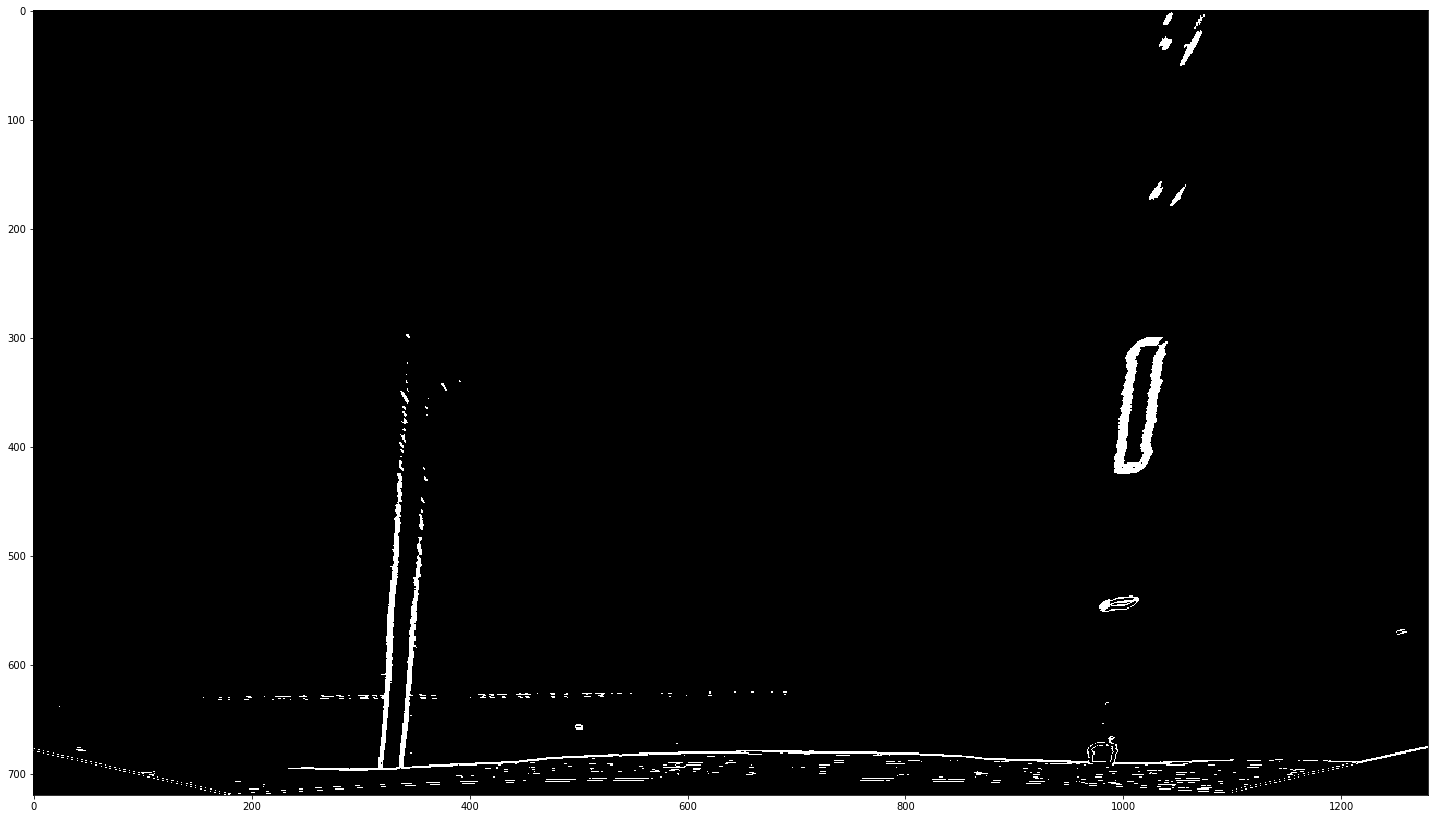

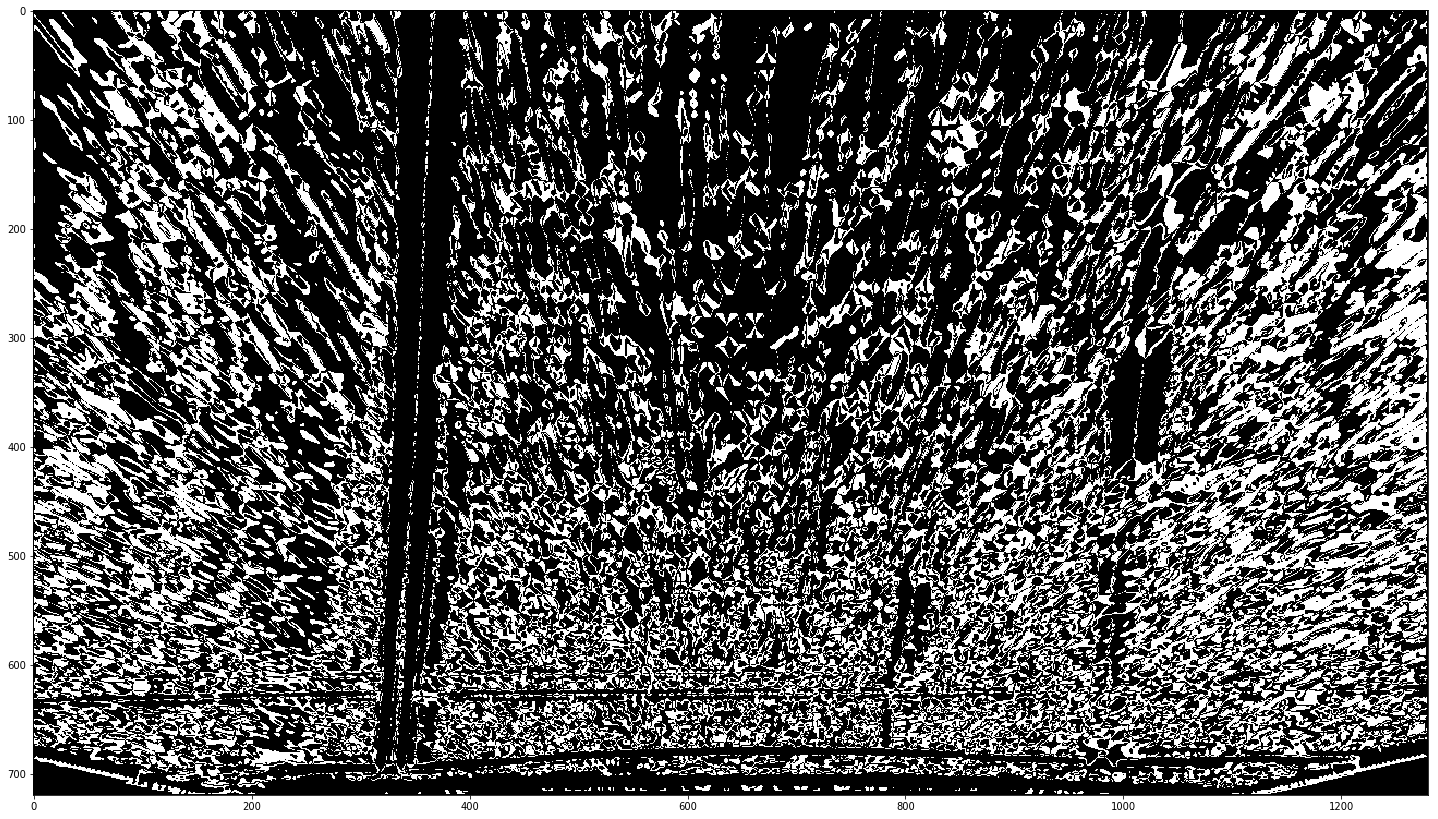

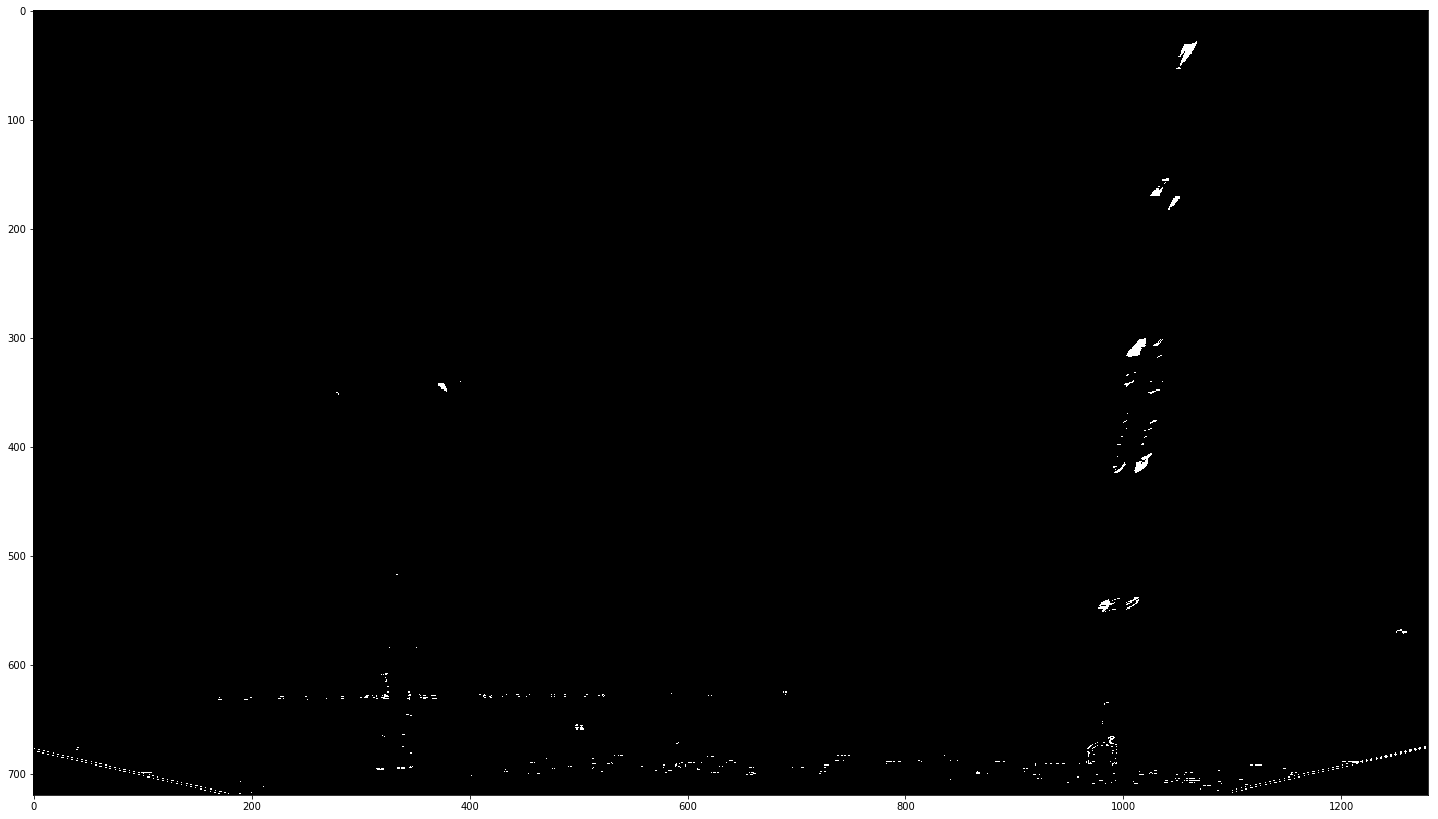

In [10]:
img = unwarpeds[0]

mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(figsize=(25,25))
plt.imshow(mag_binary, cmap='gray')

plt.figure(figsize=(25,25))
plt.imshow(dir_binary, cmap='gray')

plt.figure(figsize=(25,25))
plt.imshow(combined, cmap='gray')

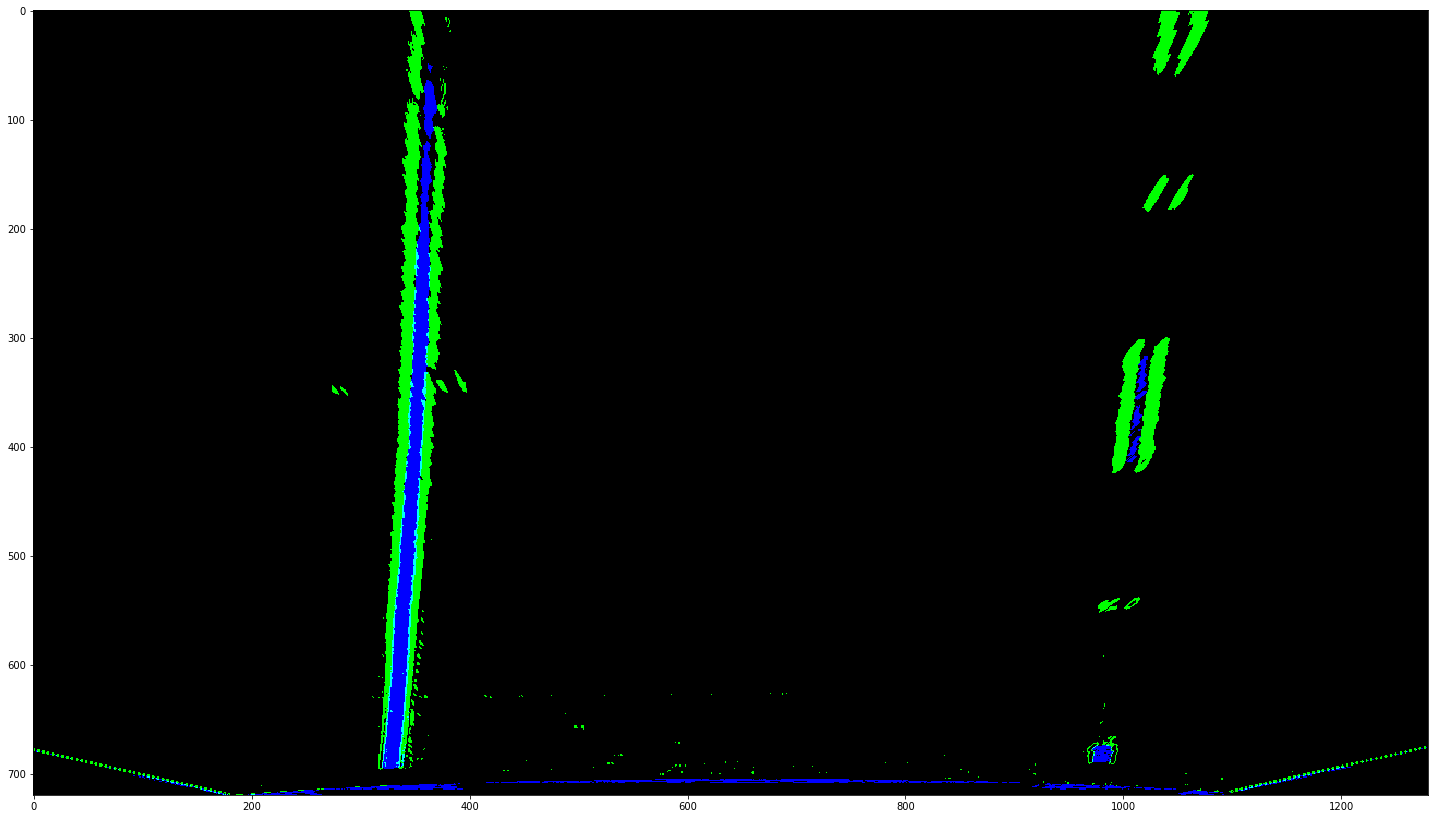

In [11]:
img = unwarpeds[0]
hls_binary = hls_select(img, s_thresh=(170, 255), sx_thresh=(20, 100))

plt.figure(figsize=(25,25))
plt.imshow(hls_binary)

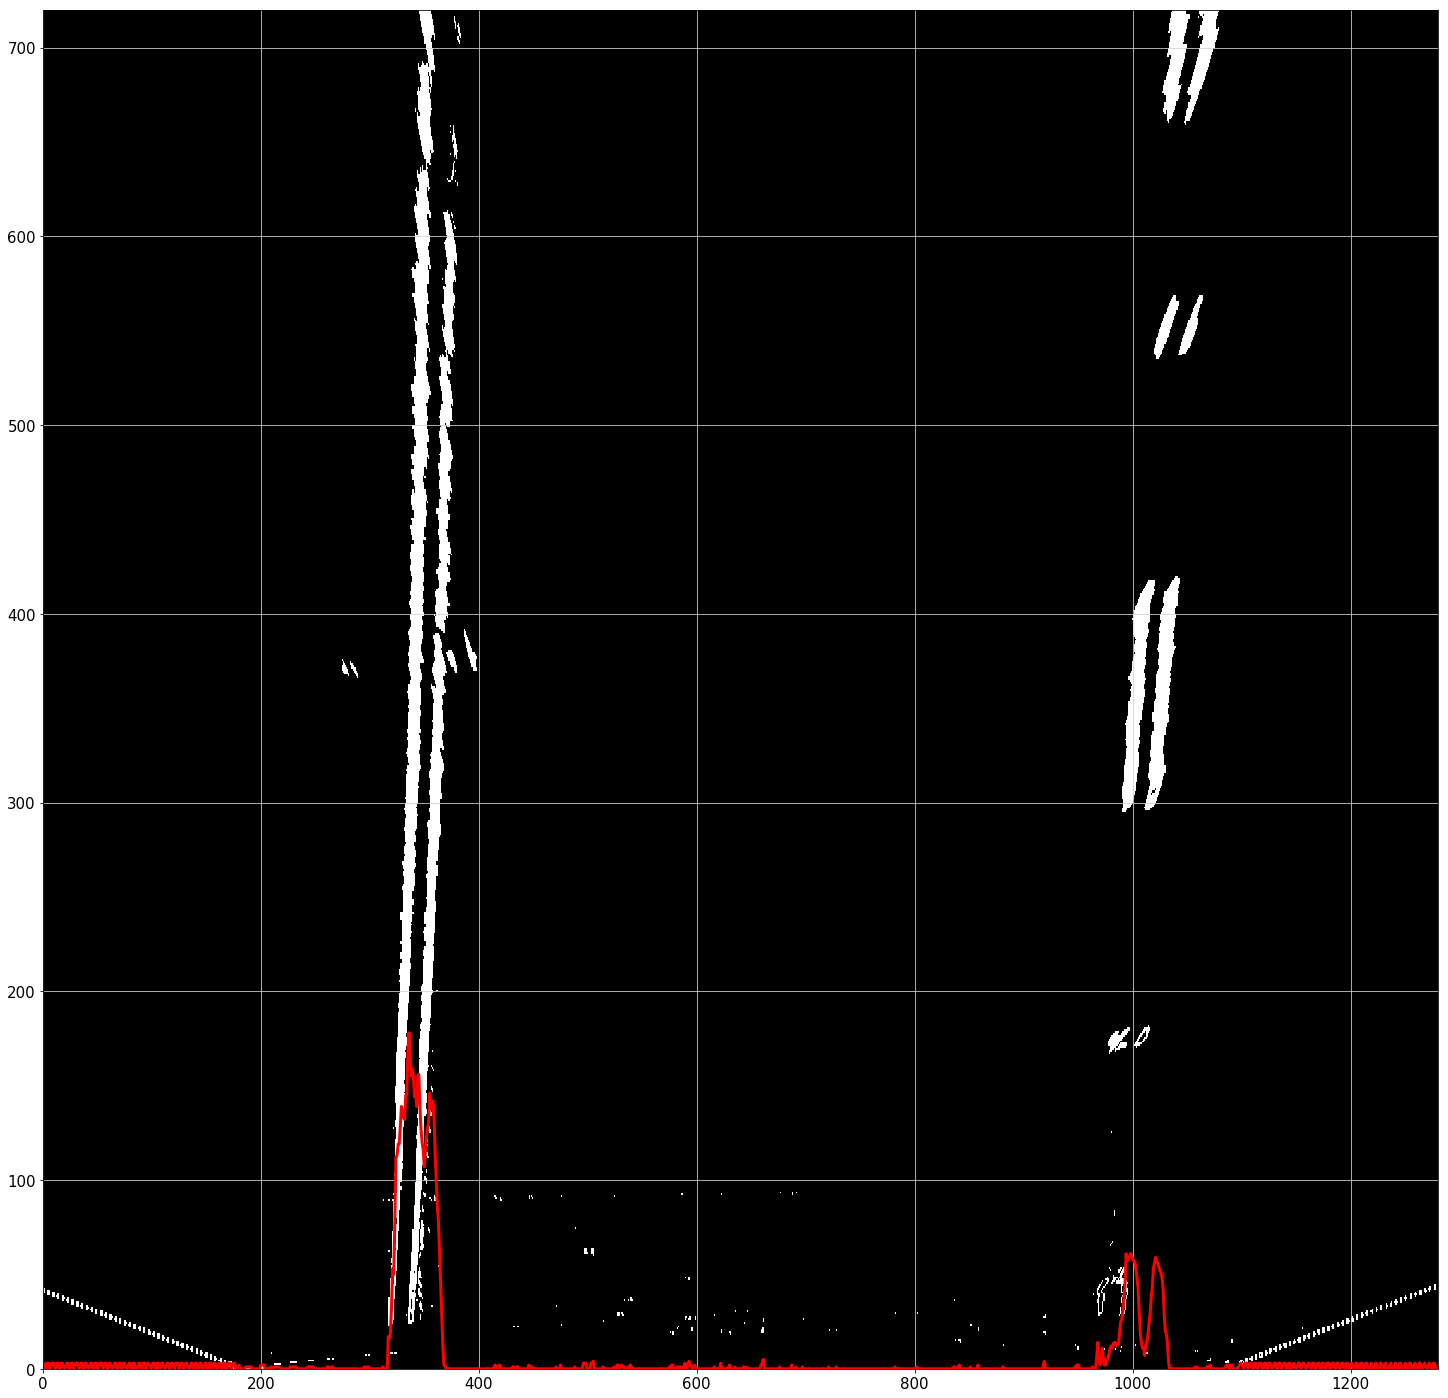

In [12]:
# img = unwarpeds[0]
# half_height = int(img.shape[0] / 2)
# max_y = 0

# plt.figure(figsize=(10,10))
# fig, ax = plt.subplots()
# ax.yaxis.tick_left()
# ax.tick_params(axis='y', colors='black', labelsize=15)
# ax.tick_params(axis='x', colors='black', labelsize=15)
# ax.grid(b=True, which='major', color='#D3D3D3', linestyle='-')

# for i, color in enumerate(['red', 'green', 'blue']):
#     hist = np.sum(img[half_height:,:,i], axis=0)
#     ax.plot(hist, '-o', ms=3, lw=1, alpha=1.0, color=color)
#     max_y = max(max(hist), max_y)
    
# ax.imshow(img, aspect='auto', extent=(0, img.shape[1], 0, max_y), zorder=-1)
# plt.show()

img = gradx
half_height = int(img.shape[0] / 2)
max_y = 0
histogram = np.sum(img[half_height:,:], axis=0)

plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax.yaxis.tick_left()
ax.tick_params(axis='y', colors='black', labelsize=15)
ax.tick_params(axis='x', colors='black', labelsize=15)
ax.grid(b=True, which='major', color='#D3D3D3', linestyle='-')
ax.plot(histogram, lw=3, color='red')
ax.imshow(img, aspect='auto', extent=(0, img.shape[1], 0, 720), zorder=-1, cmap='gray')
plt.show()

(720, 0)

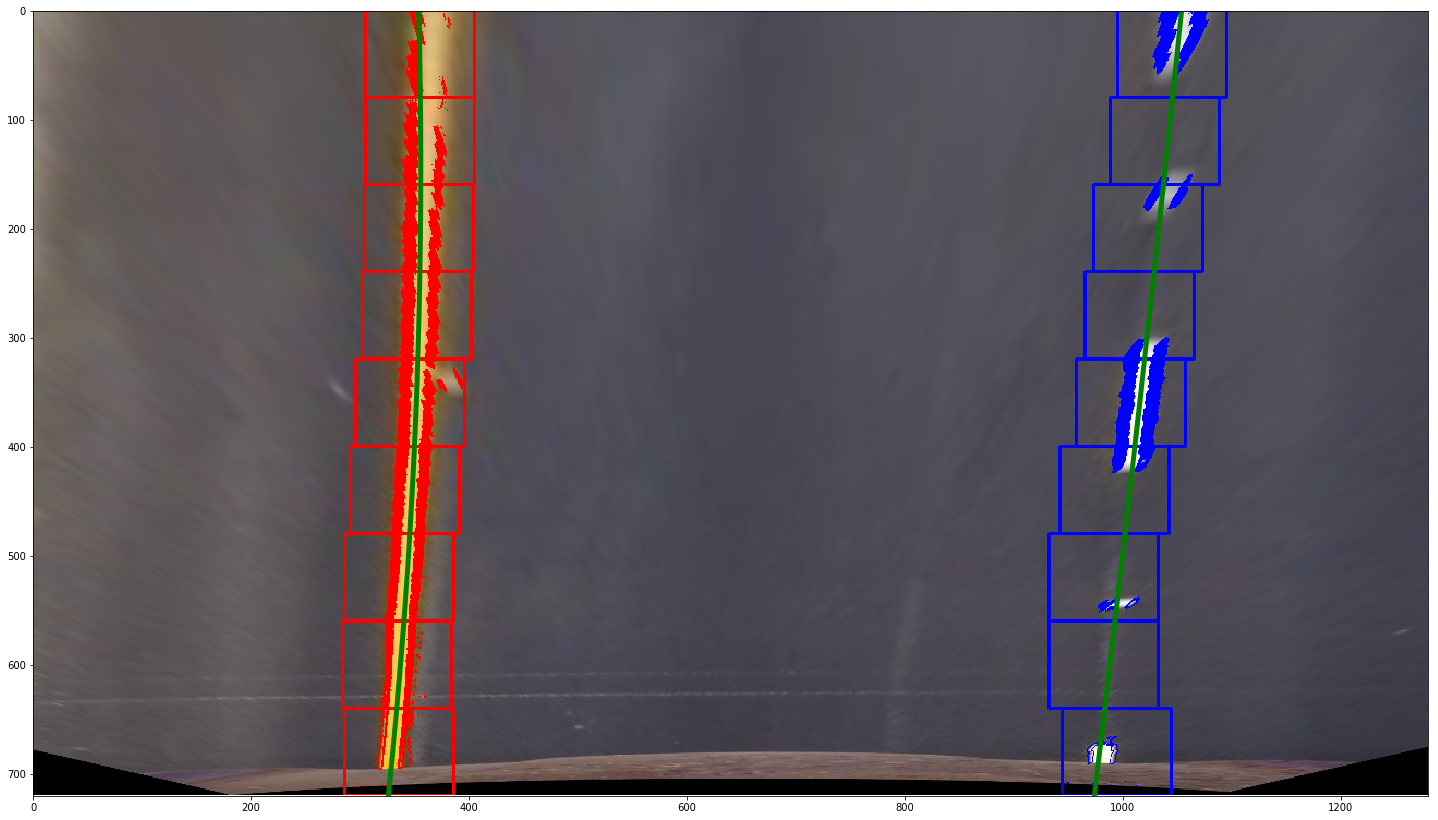

In [30]:
out_img = np.copy(unwarpeds[0])

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0] / 2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
window_height = np.int(img.shape[0] / nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = img.shape[0] - (window + 1) * window_height
    win_y_high = img.shape[0] - window * window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (255,0,0), 2) 
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,0,255), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) 
                      & (nonzeroy < win_y_high) 
                      & (nonzerox >= win_xleft_low) 
                      & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) 
                       & (nonzeroy < win_y_high) 
                       & (nonzerox >= win_xright_low) 
                       & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
plt.figure(figsize=(25,25))
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)

left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
plt.plot(left_fitx, ploty, color='green', lw=5)
    
right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
plt.plot(right_fitx, ploty, color='green', lw=5)
    
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [31]:
# def window_mask(width, height, img_ref, center,level):
#     output = np.zeros_like(img_ref)
#     output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
#     return output

# def find_window_centroids(image, window_width, window_height, margin):
#     window_centroids = [] # Store the (left,right) window centroid positions per level
#     window = np.ones(window_width) # Create our window template that we will use for convolutions
    
#     # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
#     # and then np.convolve the vertical image slice with the window template 
#     # Sum quarter bottom of image to get slice, could use a different ratio
#     half_width = int(image.shape[1] / 2)
#     quarter_height = int(3 * image.shape[0] / 4)
#     left_part = image[quarter_height:, :half_width]
#     right_part = image[quarter_height:, half_width:]
    
#     l_sum = np.sum(left_part, axis=0)
#     l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2
    
#     r_sum = np.sum(right_part, axis=0)
#     r_center = np.argmax(np.convolve(window, r_sum)) - window_width / 2 + half_width
    
#     # Add what we found for the first layer
#     window_centroids.append((l_center, r_center))
#     print(window_centroids)
    
#     # Go through each layer looking for max pixel locations
#     for level in range(1,(int)(warped.shape[0]/window_height)):
#         # convolve the window into the vertical slice of the image
#         image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
#         conv_signal = np.convolve(window, image_layer)
#         # Find the best left centroid by using past left center as a reference
#         # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
#         offset = window_width/2
#         l_min_index = int(max(l_center+offset-margin,0))
#         l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
#         l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
#         # Find the best right centroid by using past right center as a reference
#         r_min_index = int(max(r_center+offset-margin,0))
#         r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
#         r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
#         # Add what we found for that layer
#         window_centroids.append((l_center,r_center))

#     return window_centroids

# warped = np.copy(img)
# window_width = 50 
# window_height = 80 # Break image into 9 vertical layers since image height is 720
# margin = 100 # How much to slide left and right for searching

# window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# # If we found any window centers
# if len(window_centroids) > 0:
#     # Points used to draw all the left and right windows
#     l_points = np.zeros_like(warped)
#     r_points = np.zeros_like(warped)

#     # Go through each level and draw the windows    
#     for level in range(0,len(window_centroids)):
#         # Window_mask is a function to draw window areas
#         l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
#         r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
#         # Add graphic points from window mask here to total pixels found 
#         l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#         r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

#     # Draw the results
#     template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#     zero_channel = np.zeros_like(template) # create a zero color channel
#     template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#     warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
#     output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
# # If no window centers found, just display orginal road image
# else:
#     output = np.array(cv2.merge((warped, warped, warped)),np.uint8)

# # Display the final results
# plt.imshow(output)
# plt.title('window fitting results')
# plt.show()

5627.67670398 41890.2368934
1819.57887847 m 13472.5982305 m


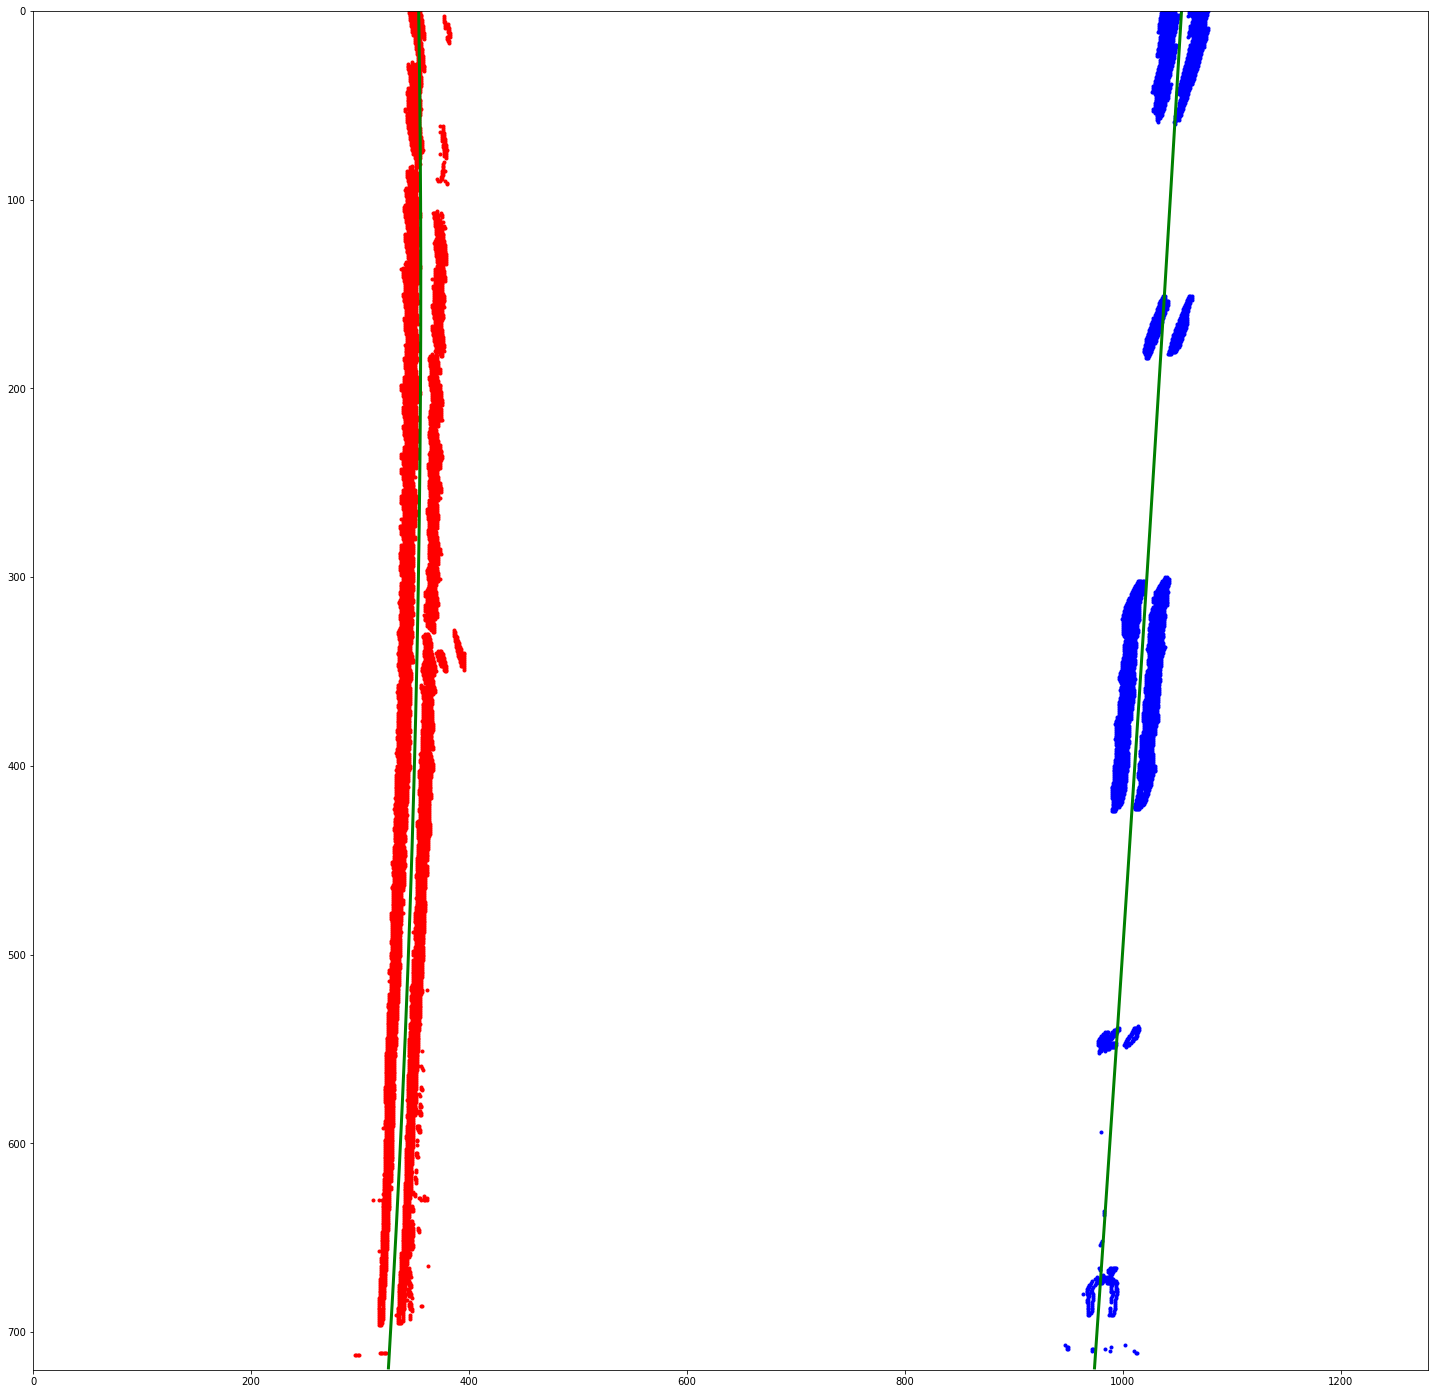

In [36]:
# Generate some fake data to represent lane-line pixels
# ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
# rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
# leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

mark_size = 3
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# Example values: 1926.74 1908.48


#  the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

(720, 1280, 3)


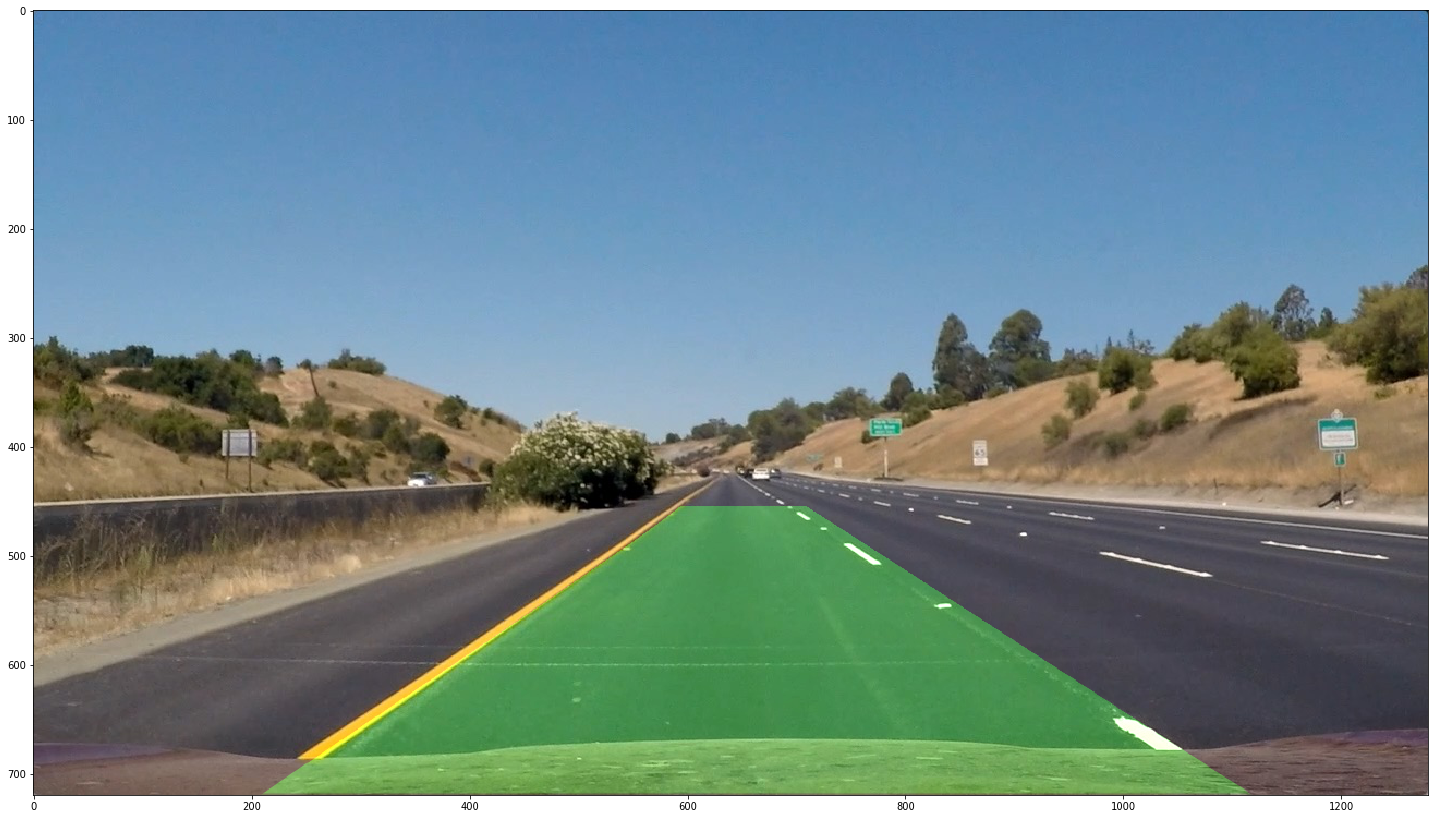

In [48]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

undist = images_dist[0]
bottom_y = undist.shape[0] - 1
bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

xm_per_pix = 3.7/700 # meters per pixel in x dimension
vehicle_offset *= xm_per_pix

# Create an image to draw the lines on
ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# warp_zero = np.zeros_like(warped).astype(np.uint8)
# color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
color_warp = np.zeros((720, 1280, 3), dtype='uint8')
print(color_warp.shape)
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
aaa = cv2.cvtColor(images_dist[0], cv2.COLOR_BGR2RGB)
result = cv2.addWeighted(aaa, 1, newwarp, 0.3, 0)
plt.imshow(result)

# def final_viz(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset):
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     # Create an image to draw the lines on
#     color_warp = np.zeros((720, 1280, 3), dtype='uint8')  # NOTE: Hard-coded image dimensions

#     # Recast the x and y points into usable format for cv2.fillPoly()
#     pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#     pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
#     pts = np.hstack((pts_left, pts_right))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

#     # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = cv2.warpPerspective(color_warp, m_inv, (undist.shape[1], undist.shape[0]))
#     # Combine the result with the original image
#     result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

#     # Annotate lane curvature values and vehicle offset from center
# #     avg_curve = (left_curve + right_curve)/2
# #     label_str = 'Radius of curvature: %.1f m' % avg_curve
# #     result = cv2.putText(result, label_str, (30,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)

# #     label_str = 'Vehicle offset from lane center: %.1f m' % vehicle_offset
# #     result = cv2.putText(result, label_str, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)

#     return result

# undist = images_dist[0]
# bottom_y = undist.shape[0] - 1
# bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
# bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
# vehicle_offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

# xm_per_pix = 3.7/700 # meters per pixel in x dimension
# vehicle_offset *= xm_per_pix
    
# result = final_viz(undist, left_fit, right_fit, Minv, left_fit_cr, right_fit_cr, vehicle_offset)
# plt.imshow(result)
